### Popmodel EDA
###### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from xgboost import XGBClassifier, XGBRFClassifier

import imblearn

import sweetviz as sv

###### Notebook Settings

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

###### Feature Engineering

In [ ]:
#Read CSVs
data = pd.read_csv("SpotifyData.csv")
add_infos = pd.read_csv("additional_infos.csv")

In [ ]:
#Adjust inconsistent genre naming
data.loc[data["genre"] == 'Children’s Music', "genre"] = "Children Music"
data.loc[data["genre"] == "Children's Music", "genre"] = "Children Music"

In [ ]:
#Join duplicate tracks assigned to different genres together in one common row
genre_df = data.groupby(['track_id'])['genre'].apply(', '.join).reset_index()

In [ ]:
#Drop duplicates by track ID and remove ID column
data.drop_duplicates("track_id", inplace=True)
data.sort_values("track_id", inplace=True)
data.reset_index(inplace=True, drop=True)

In [ ]:
#Assign Features
X = data

In [ ]:
#Replace genre column in original dataset
X["genre"] = genre_df["genre"]

In [ ]:
#Genre encoding seperate since there can be multiple values in one row
X = pd.concat([X, X['genre'].str.get_dummies(sep=', ')], axis=1)
X = pd.concat([X, pd.get_dummies(X[["key","mode","time_signature"]])], axis=1)
X.drop(["key","mode","time_signature","genre"], axis=1, inplace=True)

In [ ]:
#Add explicit feature from external dataset
add_infos.sort_values("id", inplace=True)
assert pd.Series(add_infos["id"].values == X["track_id"].values).value_counts().values[0] == len(add_infos)
X["explicit"] = add_infos["explicit"]
X["track_number"] = add_infos["track_number"]

In [ ]:
#Get release Date from String and create new feature
temp = []
for i in range(len(add_infos)):
    temp += [int(add_infos["album"][i][add_infos["album"][i].find("release_date") + 16: add_infos["album"][i].find("release_date") + 20])]
X["release_date"] = temp
X.loc[X["release_date"] == 0000, "release_date"] = X["release_date"].values.mean().round()

In [ ]:
#Get total track number from String and create new feature
temp = []
for i in range(len(add_infos)):
    if add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 16] == ",":
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 16])]
    elif add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 17] == ",":
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 17])]
    else:
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 18])]
X["total_tracks"] = temp

In [ ]:
#Get artist id from String and create new feature
temp = []
for i in range(len(add_infos)):
    temp += [add_infos["album"][i][add_infos["album"][i].find("id") + 6: add_infos["album"][i].find("id") + 28]]
X["artist_id"] = temp

In [ ]:
#encoding track id and artist
lenc = OrdinalEncoder()
X["track_id"] = lenc.fit_transform(X["track_id"].values.reshape(-1,1))
X["artist_id"] = lenc.fit_transform(X["artist_id"].values.reshape(-1,1))
X["track_name"] = lenc.fit_transform(X["track_name"].values.reshape(-1,1))
X["artist_name"] = lenc.fit_transform(X["artist_name"].values.reshape(-1,1))

In [ ]:
#Drop Songs with zero popularity
X.drop(X[X["popularity"] == 0].index, inplace=True)

In [ ]:
#Drop voice only audio tracks
X.drop(X[X["speechiness"] > 0.70].index, inplace=True)

In [ ]:
#Assign Prediction Target
y = X["popularity"]
X.drop(["popularity"], axis=1, inplace=True)

In [ ]:
#Class binning of y
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y = pd.DataFrame(est.fit_transform(y.values.reshape(-1, 1)))

In [ ]:
#encoding track id and artist
lenc = OrdinalEncoder()
X["track_id"] = lenc.fit_transform(X["track_id"].values.reshape(-1,1))
X["artist_id"] = lenc.fit_transform(X["artist_id"].values.reshape(-1,1))
X["track_name"] = lenc.fit_transform(X["track_name"].values.reshape(-1,1))
X["artist_name"] = lenc.fit_transform(X["artist_name"].values.reshape(-1,1))

In [ ]:
# OR! drop the former columns
X.drop(["track_id", "artist_name", "track_name", "artist_id"], axis=1, inplace=True)

In [ ]:
#Scaling all features (Brings less accuracy)
minni = MinMaxScaler()
pd.DataFrame(minni.fit_transform(X))

In [ ]:
#SweeViz
my_report = sv.analyze(data)
my_report.show_html()

In [ ]:
#SweeViz
my_report = sv.analyze(X)
my_report.show_html()

###### Models

In [ ]:
#Validation Set
X_valid = X.sample(frac=0.1,random_state=1, replace=False)
X.drop(X_valid.index, inplace=True)

y_valid = y.iloc[X_valid.index]
y.drop(y_valid.index, inplace=True)

X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X_valid.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)


In [ ]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, shuffle=True)

In [ ]:
#Over and undersampling of training data (Decreases Scores)
smote = imblearn.over_sampling.SMOTE(sampling_strategy='minority', random_state=3, n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train,y_train)
len(X)

In [ ]:
#PopModel
rfc = RandomForestClassifier(min_samples_split=11, verbose=0, n_jobs=-1, random_state=3, n_estimators=100, class_weight="balanced")

In [ ]:
#Training and testing
rfc.fit(X_train, y_train)

print("\nTrainings Score: %0.2f" % (rfc.score(X_train, y_train)) + "\n\n")
print("Test Score Report:\n")

pred_test = rfc.predict(X_test)

target_names = ["Not popular", "Popular", "Very popular"]
print(classification_report(y_test, pred_test, target_names=target_names))

In [155]:
#Calculating Feature Importance
plt.rcParams.update({'figure.figsize': (16.0, 9.0)})
plt.rcParams.update({'font.size': 15, 'grid.alpha': 1})


importances = rfc.feature_importances_
indices = np.argsort(importances)
features = X.columns

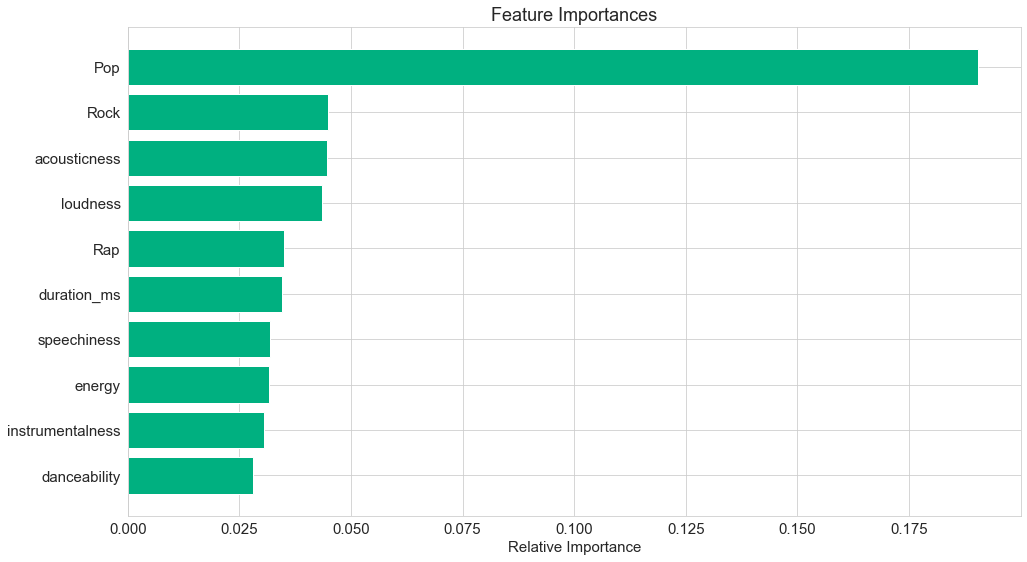

In [156]:
plt.title('Feature Importances')
plt.barh(range(len(indices[53:])), importances[indices][53:], color=(0,0.69,0.5,1), align='center')
plt.yticks(range(len(indices[53:])), [features[i] for i in indices[53:]])
plt.xlabel('Relative Importance')
plt.savefig('feature_imp.png')
plt.show()

In [145]:
importances[53:]




array([2.62901798e-02, 2.21336484e-02, 2.08064993e-02, 4.47289558e-02,
       2.80229151e-02, 3.45958541e-02, 3.16108805e-02, 3.04909214e-02,
       2.75538440e-02, 4.34280489e-02, 3.18664639e-02, 2.28939924e-02,
       2.53580027e-02, 9.83100277e-05, 1.22707460e-02, 1.74652393e-02,
       4.29254850e-03, 8.88702663e-03, 2.17715638e-03, 9.00101053e-03,
       1.47118996e-02, 2.12041474e-02, 2.85257242e-03, 1.84234012e-02,
       2.66318823e-02, 1.26514619e-02, 1.18931410e-02, 1.60514667e-02,
       1.16489654e-02, 1.90475259e-01, 1.18628482e-02, 3.49699645e-02,
       4.92805909e-03, 3.29387217e-03, 4.48513666e-02, 1.10054555e-02,
       1.40481217e-02, 2.02290982e-03, 2.93090045e-03, 2.16238909e-03,
       1.76452428e-03, 1.92337571e-03, 2.20252554e-03, 2.12919196e-03,
       2.05815482e-03, 1.23446295e-03, 1.76607037e-03, 1.90100395e-03,
       1.96379499e-03, 2.10590679e-03, 1.83302061e-03, 2.23595576e-03,
       2.26078071e-03])

In [ ]:
#Cross Validation
scores = cross_validate(rfc, X, y.values.ravel(), cv=5, scoring=('f1_micro', "f1_macro", 'accuracy', "balanced_accuracy"), return_train_score=True)

print("test_f1_micro: %0.2f (+/- %0.2f)" % (scores["test_f1_micro"].mean(), scores["test_f1_micro"].std() * 2))
print("test_f1_macro: %0.2f (+/- %0.2f)" % (scores["test_f1_macro"].mean(), scores["test_f1_macro"].std() * 2))
print("test_accuracy: %0.2f (+/- %0.2f)" % (scores["test_accuracy"].mean(), scores["test_accuracy"].std() * 2))
print("test_balanced_accuracy: %0.2f (+/- %0.2f)" % (scores["test_balanced_accuracy"].mean(), scores["test_balanced_accuracy"].std() * 2))

In [ ]:
#validation
pred_valid = rfc.predict(X_valid)

print("Test Score Report:\n")
print(classification_report(y_valid, pred_valid, target_names=target_names))

In [ ]:
#Export True values vs. prediction
d= {"True":list(y_valid._series[0]), "Predict":pred_valid.tolist()}
erg = pd.DataFrame(d)
erg.to_csv("erg.csv")
erg

In [ ]:
###GridSearchCV


params = {
           "max_depth": [70, 120, 180, 500]

           }

gsearch = GridSearchCV(estimator=m,
                       param_grid=params,
                       cv=2,
                       verbose=1,
                       n_jobs=-1
                       )

In [ ]:
#Additional Model Testing

modelx = imblearn.ensemble.BalancedBaggingClassifier(n_jobs=-1) #0.75 weighted avg
modelx = KNeighborsClassifier(n_jobs=-1) #0.54 weighted avg
modelx = SVC() #too slow for size of dataset
modelx = GaussianNB() #0.56 weighted avg
modelx = DecisionTreeClassifier() #0.75 weighted avg
modelx = BaggingClassifier(verbose=1, n_jobs=-1) #0.78 weighted avg, 0.79 Accuracy, 0.64 macro avg
modelx = XGBRFClassifier(n_jobs=-1) #0.73 weighted avg

modelx = XGBClassifier(seed=27, objective='multi:softprob', colsample_bytree=0.8, subsample=0.5,
                       gamma=0, min_child_weight=1, max_depth=10, n_estimators=1000, learning_rate =0.1,
                       sampling_method="gradient_based", random_state=3, n_jobs=-1, tree_method='gpu_hist',
                       predictor= 'gpu_predictor', verbosity=3) #0.80 weighted avg, 0.67 Accuracy, 0.80 macro avg



In [ ]:
%%time
modelx.fit(X_train, y_train.values.ravel())

print("\nTrainings Score: %0.2f" % (modelx.score(X_train, y_train)) + "\n\n")
print("Test Score Report:\n")

pred_test = modelx.predict(X_test)

target_names = ["Not popular", "Popular", "Very popular"]
print(classification_report(y_test, pred_test, target_names=target_names))

In [ ]:

from sklearn.ensemble import AdaBoostClassifier #No Increase in performance

adb = AdaBoostClassifier(base_estimator=rfc, n_estimators=10, random_state=3)

adb.fit(X_train, y_train)

adb_pred = adb.predict(X_test)

print(classification_report(y_test, adb_pred, target_names=target_names))

In [ ]:
%%time

from sklearn.ensemble import GradientBoostingClassifier #No Increase in performance

gb = GradientBoostingClassifier(random_state=3, n_estimators=50)

gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)

print(classification_report(y_test, gb_pred, target_names=target_names))